In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np  
from scipy.spatial.distance import pdist, squareform
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
%matplotlib inline

In [2]:
def plot_map_lg(ax,x,y,z,vmin,vmax,cmap):

    ax.set_global()

    ax.add_feature(cfeature.LAND.with_scale('110m'),color='.9')
    ax.coastlines()
    gl = ax.gridlines(crs=xccrs.PlateCarree(), draw_labels=True, 
                      linewidth=1, color='gray', alpha=0.5, linestyle='-')    
    gl.left_labels = True
    gl.right_labels = False 
    gl.top_labels = False 
    gl.bottom_labels = True
    XTEXT_SIZE = 14
    YTEXT_SIZE = XTEXT_SIZE
    # to facilitate text rotation at bottom edge, ...
    # text justification: 'ha':'right' is used to avoid clashing with map's boundary
    # default of 'ha' is center, often causes trouble when text rotation is not zero
    gl.xlabel_style = {'size': XTEXT_SIZE, 'color': 'k', 'rotation':0, 'ha':'center'}
    gl.ylabel_style = {'size':YTEXT_SIZE, 'color': 'k', 'weight': 'normal'}

    filled=plt.scatter(x=x, y=y, vmin=vmin, vmax=vmax,
            c=z, cmap=cmap,  #this is the changes            
            s=70,
            alpha=1,
            edgecolors= "grey",
            linewidth=1,            
            marker='o',
            zorder=3,
            transform=xccrs.PlateCarree()) ## Important
    # plt.rcParams["axes.edgecolor"] = "black"
    # plt.rcParams["axes.linewidth"] = 1
    return filled

## Data I/O using Dask

### Create Dask Cluster

In [12]:
cluster.close()
client.close()

In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='UARH0002',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/clittle/conda-envs/sealevel-analysis/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/work/clittle/conda-envs/sealevel-analysis/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35143 instead
  warnings.warn(


In [6]:
cluster

## define set of "pseudo-tgs"

In [3]:
# tgs_in = pd.read_pickle("pseudo_tgs_in.pkl")
tgs_in = pd.read_csv('coast-no-lakes.csv',header=None, names=["lat", "lon"])
tgs_in['name'] = tgs_in.index
tgs_in=tgs_in[::200]
# tgs_in=tgs_in[::2]
tgs_in=tgs_in.dropna()

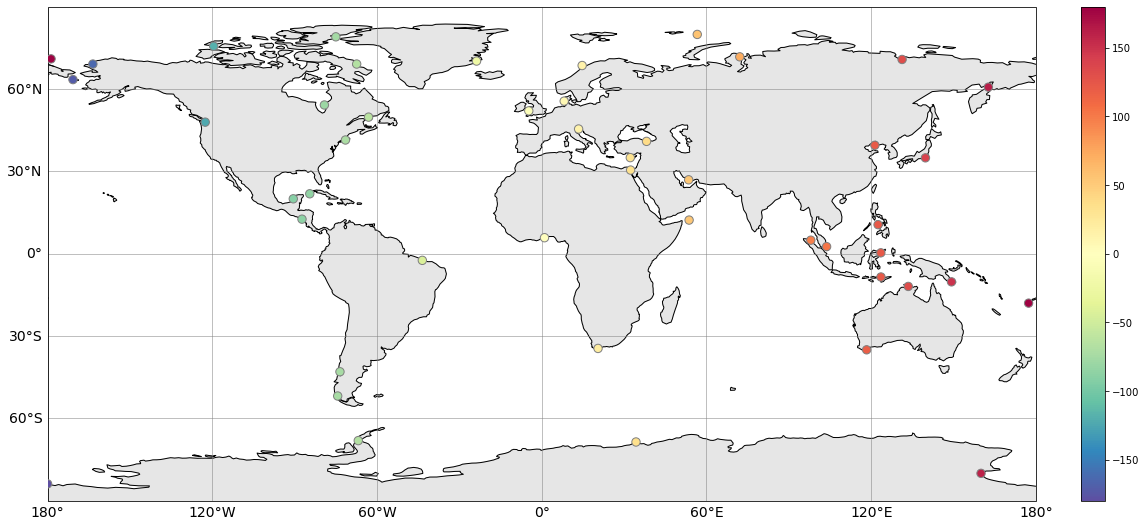

In [4]:
vmin=-180
vmax=180
cmap='Spectral_r'

fig = plt.figure(figsize=(20,20))#, tight_layout=True)
ax = fig.add_subplot(2,1,1, projection=xccrs.PlateCarree())
pos = ax.get_position() # get the original position 
z=tgs_in.lon
filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
fig.colorbar(filled1,fraction=0.046, pad=0.04)

In [5]:
# lat_long = pd.DataFrame({'LATITUDE': [-22.98, -22.97, -22.92, -22.87, -22.89], 'LONGITUDE': [-43.19, -43.39, -43.24, -43.28, -43.67]})
lat_long=tgs_in[['lat','lon']]
lat_long.reset_index(inplace=True,drop=True)

def dist(x, y):
    """Function to compute the distance between two points x, y"""

    lat1 = radians(x[0])
    lon1 = radians(x[1])
    lat2 = radians(y[0])
    lon2 = radians(y[1])

    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return round(distance, 4)


distances = pdist(lat_long.values, metric=dist)

points = [f'point_{i}' for i in range(1, len(lat_long) + 1)]

result = pd.DataFrame(squareform(distances), columns=tgs_in.name, index=tgs_in.name)

# print(result)
# msk = np.tril(result < 200, k=-1).any(axis=1)
# # tgs_in = tgs_in[~msk]
# msk.shape

In [6]:
def finddups(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    for i in range(len(dataset.columns)):
        for j in range(i):
            if (dataset.iloc[i, j] <= threshold) and (dataset.columns[j] not in col_corr):
                colname = dataset.columns[i] # getting the name of column
                col_corr.add(colname)
                # if colname in dataset.columns:
                #     del dataset[colname] # deleting the column from the dataset
    # print(dataset)
    return col_corr

repeattgs=finddups(result,250)

In [7]:
tgs_in=tgs_in.drop(repeattgs)

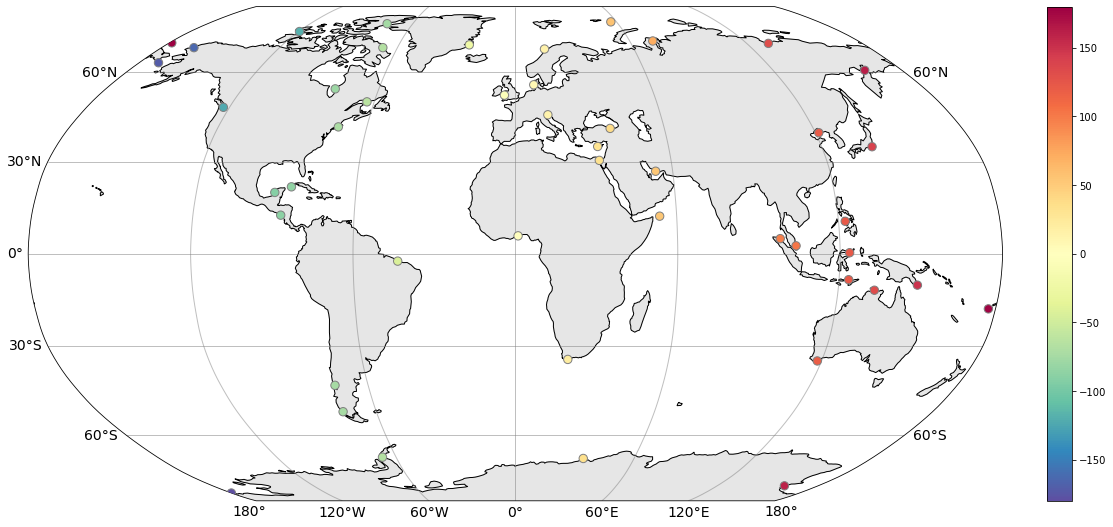

In [8]:
fig = plt.figure(figsize=(20,20))#, tight_layout=True)
ax = fig.add_subplot(2,1,1, projection=xccrs.Robinson())
pos = ax.get_position() # get the original position 
z=tgs_in.lon
# z=z.to_frame()
# z.columns=['cycle3']
# z['cycle2']=(np.var(fosi_ibcorr_anndet)/np.var(hr_ibcorr_anndet2))
# z['cycle4']=(np.var(fosi_ibcorr_anndet)/np.var(hr_ibcorr_anndet4))
# z=z.mean(axis=1)

filled1=plot_map_lg(ax, tgs_in.lon, tgs_in.lat, z, vmin, vmax, cmap)
# plot_focus_tgs(tt,focus_locs,z,vmin,vmax,cmap)
# place_cbar(fig,filled1,pos,xshift,yshift,cb_w,cb_h,'HR-LR SD (cm)')
fig.colorbar(filled1,fraction=0.046, pad=0.04)

In [9]:
tgs_in.to_pickle("./pseudo_tgs_in.pkl")